In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load the three CSV files
day_0 = pd.read_csv("data/prices_round_1_day_0.csv",  sep=';')
day_minus_1 = pd.read_csv("data/prices_round_1_day_-1.csv",  sep=';')
day_minus_2 = pd.read_csv("data/prices_round_1_day_-2.csv",  sep=';')

# Preview the data
day_0.head(), day_minus_1.head(), day_minus_2.head()


(   day  timestamp           product  bid_price_1  bid_volume_1  bid_price_2  \
 0    0          0  RAINFOREST_RESIN         9998             1       9995.0   
 1    0          0              KELP         2028            30          NaN   
 2    0          0         SQUID_INK         1968            30          NaN   
 3    0        100         SQUID_INK         1969             4       1967.0   
 4    0        100              KELP         2030             4       2028.0   
 
    bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ask_volume_1  \
 0          30.0          NaN           NaN        10005            30   
 1           NaN          NaN           NaN         2032            30   
 2           NaN          NaN           NaN         1971            30   
 3          31.0          NaN           NaN         1971            31   
 4          31.0          NaN           NaN         2032            31   
 
    ask_price_2  ask_volume_2  ask_price_3  ask_volume_3  mid_price  \
 

In [3]:
# Combine all days into a single dataframe
all_data = pd.concat([day_minus_2, day_minus_1, day_0], ignore_index=True)

# Filter only KELP and SQUID_INK
kelp = all_data[all_data["product"] == "KELP"]
squid = all_data[all_data["product"] == "SQUID_INK"]

# Merge on day and timestamp
merged = pd.merge(
    kelp[["day", "timestamp", "mid_price"]],
    squid[["day", "timestamp", "mid_price"]],
    on=["day", "timestamp"],
    suffixes=("_kelp", "_squid")
)

# Calculate correlation
correlation = merged["mid_price_kelp"].corr(merged["mid_price_squid"])
merged.head(), correlation


(   day  timestamp  mid_price_kelp  mid_price_squid
 0   -2          0          2000.0           2000.0
 1   -2        100          2001.0           2000.0
 2   -2        200          2000.5           1998.5
 3   -2        300          2000.5           1998.5
 4   -2        400          2000.5           1998.0,
 -0.5914885953297073)

In [4]:
correlation = merged["mid_price_squid"].iloc[3500:].corr(merged["mid_price_kelp"].iloc[:-3500])
print(correlation)

-0.6659864264541862


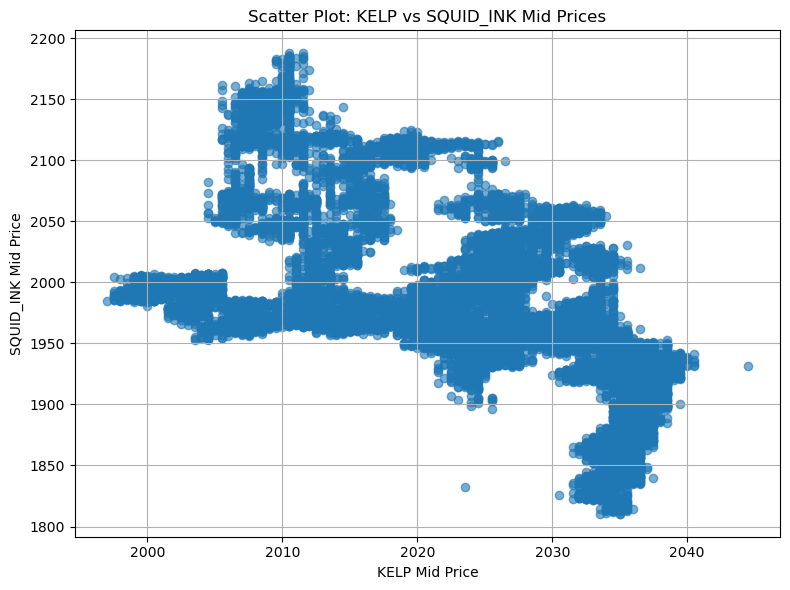

In [5]:
# Scatter plot of mid prices
plt.figure(figsize=(8, 6))
plt.scatter(merged["mid_price_kelp"], merged["mid_price_squid"], alpha=0.6)
plt.title("Scatter Plot: KELP vs SQUID_INK Mid Prices")
plt.xlabel("KELP Mid Price")
plt.ylabel("SQUID_INK Mid Price")
plt.grid(True)
plt.tight_layout()
plt.show()

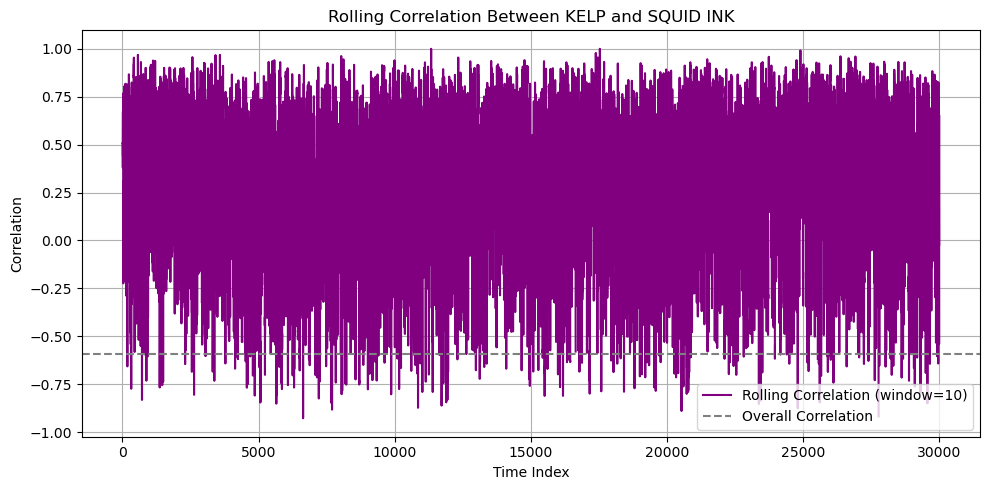

In [6]:
# Sort merged data by time to compute rolling correlation
merged_sorted = merged.sort_values(by=["day", "timestamp"]).reset_index(drop=True)

# Compute rolling correlation
window = 10  # number of time intervals
merged_sorted["rolling_corr"] = (
    merged_sorted["mid_price_kelp"]
    .rolling(window)
    .corr(merged_sorted["mid_price_squid"])
)

# Plot rolling correlation
plt.figure(figsize=(10, 5))
plt.plot(merged_sorted["rolling_corr"], label="Rolling Correlation (window=10)", color="purple")
plt.axhline(-0.59, color="gray", linestyle="--", label="Overall Correlation")
plt.title("Rolling Correlation Between KELP and SQUID INK")
plt.xlabel("Time Index")
plt.ylabel("Correlation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
filtered_merged = merged_sorted[merged_sorted["rolling_corr"].apply(lambda x: pd.notna(x) and np.isfinite(x))]
filtered_merged.describe()

,day,timestamp,mid_price_kelp,mid_price_squid,rolling_corr
count,29833.000000,29833.000000,29833.000000,29833.000000,29833.000000
mean,-1.001173,500042.385948,2023.470000,1971.185466,0.286489
std,0.816434,288694.612197,10.895414,67.886734,0.365350
min,-2.000000,0.000000,1997.000000,1810.500000,-0.927816
25%,-2.000000,249700.000000,2014.500000,1936.500000,0.043991
50%,-1.000000,500000.000000,2025.000000,1965.000000,0.338418
75%,0.000000,750200.000000,2033.500000,1999.500000,0.573364
max,0.000000,999900.000000,2044.500000,2187.500000,1.000000


In [8]:
merged_sorted

,day,timestamp,mid_price_kelp,mid_price_squid,rolling_corr
0,-2,0,2000.0,2000.0,NaN
1,-2,100,2001.0,2000.0,NaN
2,-2,200,2000.5,1998.5,NaN
3,-2,300,2000.5,1998.5,NaN
4,-2,400,2000.5,1998.0,NaN
...,...,...,...,...,...
29995,0,999500,2033.5,1831.5,-0.241732
29996,0,999600,2033.5,1833.0,-0.539224
29997,0,999700,2034.5,1834.5,0.654276
29998,0,999800,2033.0,1838.0,-0.031918


### ADF test (stationarity)

In [9]:
from statsmodels.tsa.stattools import adfuller

# Supposons que tes séries sont dans `filtered_merged`
kelp_prices = filtered_merged["mid_price_kelp"].dropna()
squid_prices = filtered_merged["mid_price_squid"].dropna()

# Test ADF pour KELP
result_kelp = adfuller(kelp_prices)
print("ADF Statistic (KELP):", result_kelp[0])
print("p-value:", result_kelp[1])
print("Critical Values:", result_kelp[4])

# Test ADF pour SQUID_INK
result_squid = adfuller(squid_prices)
print("ADF Statistic (SQUID_INK):", result_squid[0])
print("p-value:", result_squid[1])
print("Critical Values:", result_squid[4])


ADF Statistic (KELP): -1.960581312924165
p-value: 0.3041196417763883
Critical Values: {'1%': -3.430569495333868, '5%': -2.861637010980013, '10%': -2.5668216359885068}
ADF Statistic (SQUID_INK): -1.3250009840382524
p-value: 0.6176581447889166
Critical Values: {'1%': -3.4305695469183908, '5%': -2.8616370337781287, '10%': -2.566821648123396}


### Iterate after differenciation

In [10]:
def difference_until_stationary(series, max_diff=5, verbose=True):
    """
    Differentiates a time series until it becomes stationary based on the ADF test.

    Parameters:
        series (pd.Series): The time series to be tested.
        max_diff (int): Maximum number of differences to try.
        verbose (bool): Whether to print the ADF test results.

    Returns:
        pd.Series: The differenced stationary series.
        int: The number of differences performed.
    """
    d = 0
    current_series = series.dropna().copy()

    while d <= max_diff:
        result = adfuller(current_series)
        adf_stat = result[0]
        p_value = result[1]
        crit_values = result[4]
        
        if verbose:
            print(f"\nDifferencing d={d}")
            print(f"ADF Statistic: {adf_stat}")
            print(f"p-value: {p_value}")
            print(f"Critical Values: {crit_values}")

        if p_value < 0.05 or adf_stat < crit_values['5%']:
            print(f"\n✅ Series is stationary after {d} difference(s).")
            return current_series, d
        
        # If not stationary, difference the series
        current_series = current_series.diff().dropna()
        d += 1

    print("\n❌ Reached max differencing without achieving stationarity.")
    return current_series, d

kelp_stationary, kelp_d = difference_until_stationary(kelp_prices)
squid_stationary, squid_d = difference_until_stationary(squid_prices)



Differencing d=0
ADF Statistic: -1.960581312924165
p-value: 0.3041196417763883
Critical Values: {'1%': -3.430569495333868, '5%': -2.861637010980013, '10%': -2.5668216359885068}

Differencing d=1
ADF Statistic: -33.57675425318812
p-value: 0.0
Critical Values: {'1%': -3.430569495333868, '5%': -2.861637010980013, '10%': -2.5668216359885068}

✅ Series is stationary after 1 difference(s).

Differencing d=0
ADF Statistic: -1.3250009840382524
p-value: 0.6176581447889166
Critical Values: {'1%': -3.4305695469183908, '5%': -2.8616370337781287, '10%': -2.566821648123396}

Differencing d=1
ADF Statistic: -27.1586382499913
p-value: 0.0
Critical Values: {'1%': -3.4305695469183908, '5%': -2.8616370337781287, '10%': -2.566821648123396}

✅ Series is stationary after 1 difference(s).


In [11]:
merged_sorted

,day,timestamp,mid_price_kelp,mid_price_squid,rolling_corr
0,-2,0,2000.0,2000.0,NaN
1,-2,100,2001.0,2000.0,NaN
2,-2,200,2000.5,1998.5,NaN
3,-2,300,2000.5,1998.5,NaN
4,-2,400,2000.5,1998.0,NaN
...,...,...,...,...,...
29995,0,999500,2033.5,1831.5,-0.241732
29996,0,999600,2033.5,1833.0,-0.539224
29997,0,999700,2034.5,1834.5,0.654276
29998,0,999800,2033.0,1838.0,-0.031918


In [12]:
merged_sorted['mid_price_kelp_diff'] = merged_sorted['mid_price_kelp'].diff()
merged_sorted['mid_price_squid_diff'] = merged_sorted['mid_price_squid'].diff()
merged_sorted

,day,timestamp,mid_price_kelp,mid_price_squid,rolling_corr,mid_price_kelp_diff,mid_price_squid_diff
0,-2,0,2000.0,2000.0,NaN,NaN,NaN
1,-2,100,2001.0,2000.0,NaN,1.0,0.0
2,-2,200,2000.5,1998.5,NaN,-0.5,-1.5
3,-2,300,2000.5,1998.5,NaN,0.0,0.0
4,-2,400,2000.5,1998.0,NaN,0.0,-0.5
...,...,...,...,...,...,...,...
29995,0,999500,2033.5,1831.5,-0.241732,0.0,1.0
29996,0,999600,2033.5,1833.0,-0.539224,0.0,1.5
29997,0,999700,2034.5,1834.5,0.654276,1.0,1.5
29998,0,999800,2033.0,1838.0,-0.031918,-1.5,3.5


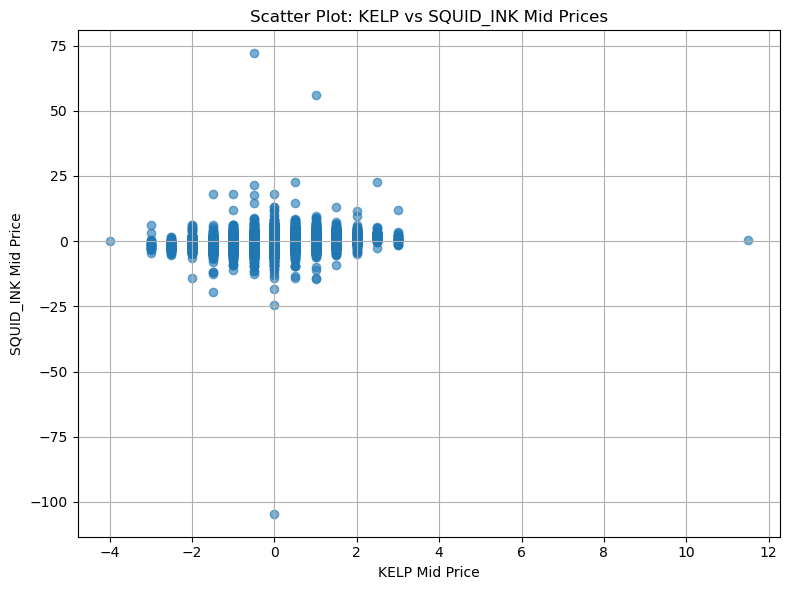

In [13]:
# Scatter plot of mid prices
plt.figure(figsize=(8, 6))
plt.scatter(merged_sorted["mid_price_kelp_diff"], merged_sorted["mid_price_squid_diff"], alpha=0.6)
plt.title("Scatter Plot: KELP vs SQUID_INK Mid Prices")
plt.xlabel("KELP Mid Price")
plt.ylabel("SQUID_INK Mid Price")
plt.grid(True)
plt.tight_layout()
plt.show()

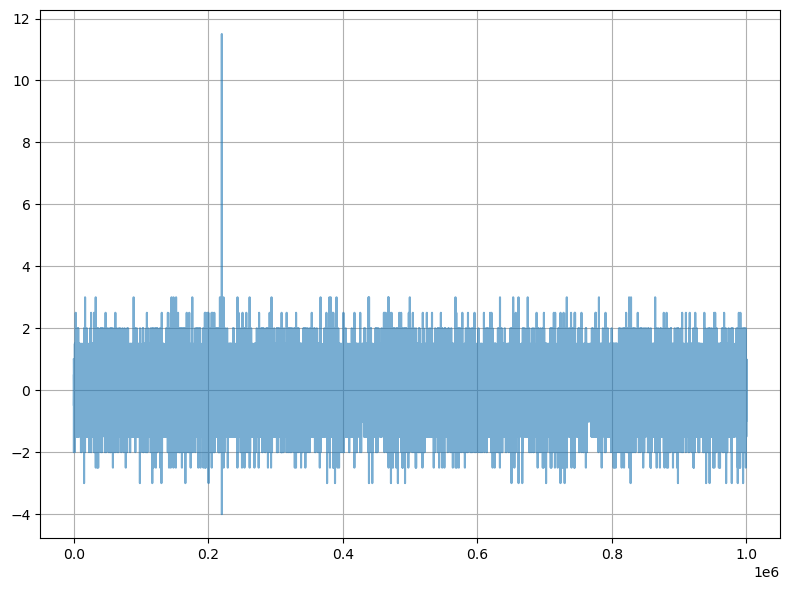

In [14]:
# Scatter plot of mid prices
plt.figure(figsize=(8, 6))
plt.plot(merged_sorted['timestamp'], merged_sorted["mid_price_kelp_diff"], alpha=0.6)

plt.grid(True)
plt.tight_layout()
plt.show()

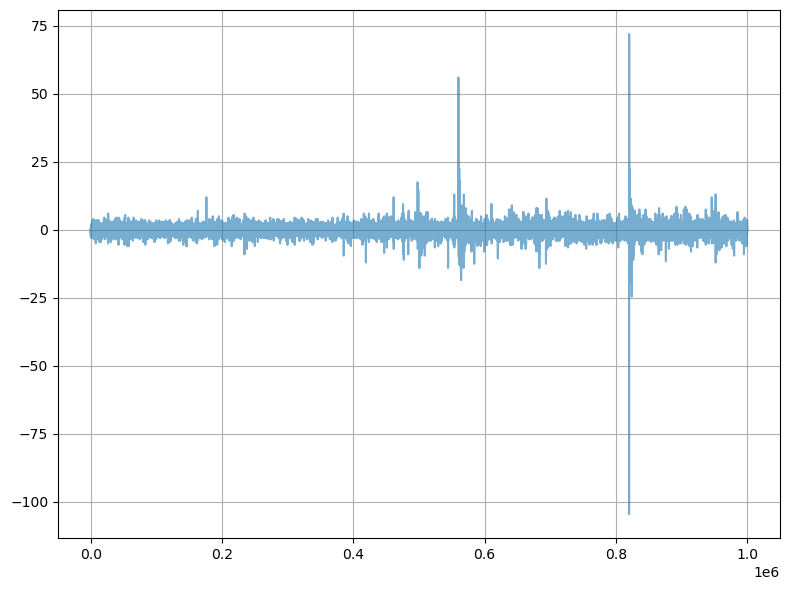

In [15]:
# Scatter plot of mid prices
plt.figure(figsize=(8, 6))
plt.plot(merged_sorted['timestamp'], merged_sorted["mid_price_squid_diff"], alpha=0.6)
plt.grid(True)
plt.tight_layout()
plt.show()

### TEst de granger (causality test)

In [16]:
from statsmodels.tsa.stattools import grangercausalitytests

# 1. Sélection des deux séries différenciées (et drop les NaN initiaux)
df_gc = merged_sorted[['mid_price_kelp_diff', 'mid_price_squid_diff']].dropna()

# 2. Granger Causality Test
# Ici, on teste les causalités dans les deux directions
max_lag = 10  # Tu peux ajuster ce nombre selon la granularité temporelle

print("🔁 Test: KELP → SQUID_INK")
grangercausalitytests(df_gc[['mid_price_squid_diff', 'mid_price_kelp_diff']], maxlag=max_lag, verbose=True)

print("\n🔁 Test: SQUID_INK → KELP")
grangercausalitytests(df_gc[['mid_price_kelp_diff', 'mid_price_squid_diff']], maxlag=max_lag, verbose=True)


🔁 Test: KELP → SQUID_INK

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=411.8671, p=0.0000  , df_denom=29995, df_num=1
ssr based chi2 test:   chi2=411.9083, p=0.0000  , df=1
likelihood ratio test: chi2=409.1059, p=0.0000  , df=1
parameter F test:         F=411.8671, p=0.0000  , df_denom=29995, df_num=1

Granger Causality
number of lags (no zero) 2


c:\Users\cam42\miniconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ssr based F test:         F=292.1121, p=0.0000  , df_denom=29992, df_num=2
ssr based chi2 test:   chi2=584.3217, p=0.0000  , df=2
likelihood ratio test: chi2=578.7034, p=0.0000  , df=2
parameter F test:         F=292.1121, p=0.0000  , df_denom=29992, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=234.2770, p=0.0000  , df_denom=29989, df_num=3
ssr based chi2 test:   chi2=702.9949, p=0.0000  , df=3
likelihood ratio test: chi2=694.8836, p=0.0000  , df=3
parameter F test:         F=234.2770, p=0.0000  , df_denom=29989, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=187.8817, p=0.0000  , df_denom=29986, df_num=4
ssr based chi2 test:   chi2=751.7526, p=0.0000  , df=4
likelihood ratio test: chi2=742.4866, p=0.0000  , df=4
parameter F test:         F=187.8817, p=0.0000  , df_denom=29986, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=151.9829, p=0.0000  , df_denom=29983, df_num=5
ssr bas

c:\Users\cam42\miniconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ssr based F test:         F=4.9075  , p=0.0074  , df_denom=29992, df_num=2
ssr based chi2 test:   chi2=9.8165  , p=0.0074  , df=2
likelihood ratio test: chi2=9.8149  , p=0.0074  , df=2
parameter F test:         F=4.9075  , p=0.0074  , df_denom=29992, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8303  , p=0.0094  , df_denom=29989, df_num=3
ssr based chi2 test:   chi2=11.4935 , p=0.0093  , df=3
likelihood ratio test: chi2=11.4913 , p=0.0093  , df=3
parameter F test:         F=3.8303  , p=0.0094  , df_denom=29989, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.6643  , p=0.0055  , df_denom=29986, df_num=4
ssr based chi2 test:   chi2=14.6615 , p=0.0055  , df=4
likelihood ratio test: chi2=14.6579 , p=0.0055  , df=4
parameter F test:         F=3.6643  , p=0.0055  , df_denom=29986, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.3689  , p=0.0048  , df_denom=29983, df_num=5
ssr bas

{1: ({'ssr_ftest': (4.721465882957435, 0.029796139421600323, 29995.0, 1),
   'ssr_chi2test': (4.7219381082499465, 0.02978015954892889, 1),
   'lrtest': (4.721566510757839, 0.029786595544757266, 1),
   'params_ftest': (4.721465882902662, 0.029796139422500003, 29995.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (4.907454190385883, 0.0073972173656135015, 29992.0, 2),
   'ssr_chi2test': (9.816544635169734, 0.007385236659173752, 2),
   'lrtest': (9.814938749099383, 0.007391168964845395, 2),
   'params_ftest': (4.907454190400394, 0.007397217365506422, 29992.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (3.8302774936728707, 0.00935604681501561, 29989.0, 3),
   'ssr_chi2test': (11.493514658729344, 0.009335763830598358, 3),
   'lrtest': (11.491313246158825, 0.009345275815988006, 3),
   'params_ftest': (3.830277493678972, 0.009356046814923073, 29989.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0

In [17]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

def granger_pval_summary(df, x_col, y_col, max_lag=10):
    """
    Crée un DataFrame résumant les p-values du test de Granger pour différents lags.
    
    x_col : prédicteur
    y_col : cible
    """
    results = {}
    
    for lag in range(1, max_lag + 1):
        test_result = grangercausalitytests(df[[y_col, x_col]], maxlag=lag, verbose=False)
        p_value = test_result[lag][0]['ssr_ftest'][1]  # On extrait la p-value du test F
        results[lag] = p_value

    return pd.DataFrame.from_dict(results, orient='index', columns=[f'{x_col} causes {y_col}'])

# Nettoyage des données (supprimer les NaN liés au différenciation)
df_gc = merged_sorted[['mid_price_kelp_diff', 'mid_price_squid_diff']].dropna()

# Générer les tableaux de p-values
kelp_to_squid = granger_pval_summary(df_gc, 'mid_price_kelp_diff', 'mid_price_squid_diff')
squid_to_kelp = granger_pval_summary(df_gc, 'mid_price_squid_diff', 'mid_price_kelp_diff')

# Combiner les deux directions dans un seul DataFrame
granger_results = pd.concat([kelp_to_squid, squid_to_kelp], axis=1)

print("\n📋 Résumé des p-values du test de Granger (par lag):")
print(granger_results)


c:\Users\cam42\miniconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\cam42\miniconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\cam42\miniconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\cam42\miniconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\cam42\miniconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\cam42\miniconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since function


📋 Résumé des p-values du test de Granger (par lag):
    mid_price_kelp_diff causes mid_price_squid_diff  \
1                                      5.876783e-91   
2                                     2.275613e-126   
3                                     2.911482e-150   
4                                     2.425505e-159   
5                                     5.950195e-160   
6                                     3.820306e-162   
7                                     5.629596e-163   
8                                     8.413668e-163   
9                                     4.485328e-162   
10                                    7.983907e-161   

    mid_price_squid_diff causes mid_price_kelp_diff  
1                                          0.029796  
2                                          0.007397  
3                                          0.009356  
4                                          0.005475  
5                                          0.004812  
6                

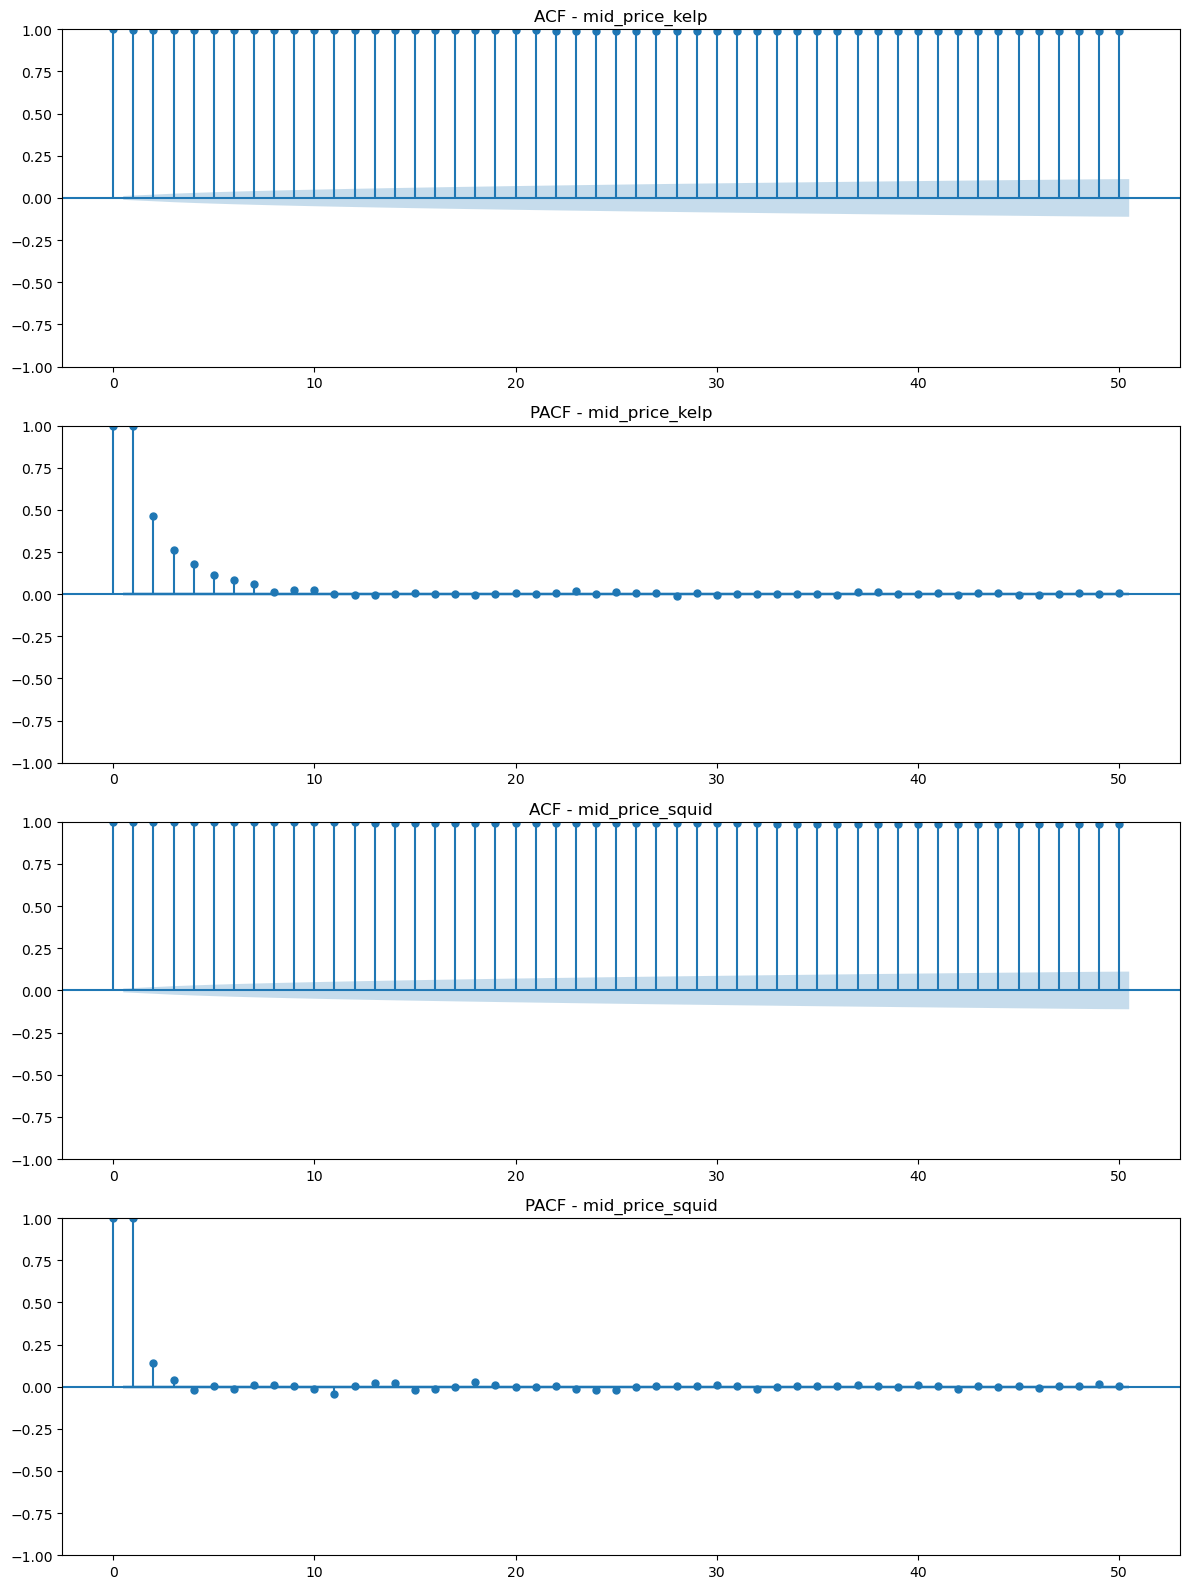

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# S'assurer que les valeurs sont bien au format Series et sans NaN
kelp = merged_sorted['mid_price_kelp'].dropna()
squid = merged_sorted['mid_price_squid'].dropna()

# Paramètres d'affichage
lags = 50  # Nombre de lags à afficher

# Création des graphiques
fig, axes = plt.subplots(4, 1, figsize=(12, 16))

# ACF KELP
plot_acf(kelp, lags=lags, ax=axes[0])
axes[0].set_title('ACF - mid_price_kelp')

# PACF KELP
plot_pacf(kelp, lags=lags, ax=axes[1], method='ywm')
axes[1].set_title('PACF - mid_price_kelp')

# ACF SQUID
plot_acf(squid, lags=lags, ax=axes[2])
axes[2].set_title('ACF - mid_price_squid')

# PACF SQUID
plot_pacf(squid, lags=lags, ax=axes[3], method='ywm')
axes[3].set_title('PACF - mid_price_squid')

plt.tight_layout()
plt.show()


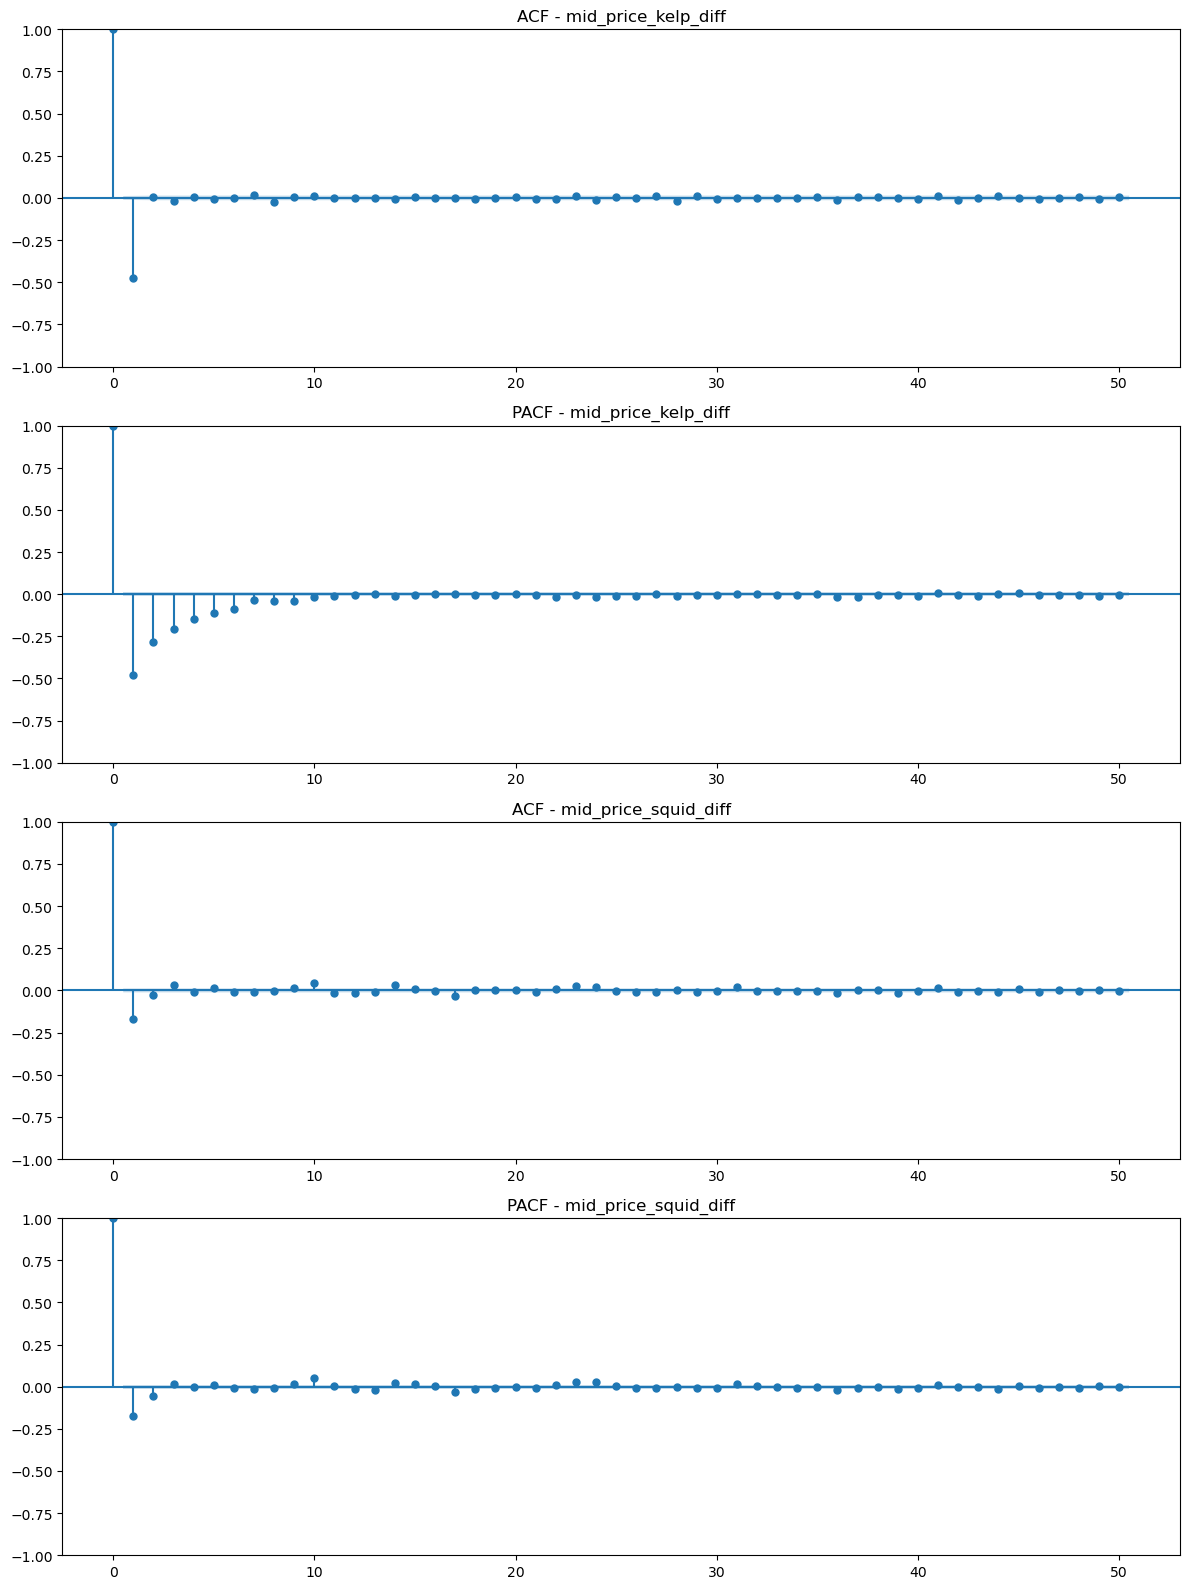

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# S'assurer que les valeurs sont bien au format Series et sans NaN
kelp_diff = merged_sorted['mid_price_kelp_diff'].dropna()
squid_diff = merged_sorted['mid_price_squid_diff'].dropna()

# Paramètres d'affichage
lags = 50  # Nombre de lags à afficher

# Création des graphiques
fig, axes = plt.subplots(4, 1, figsize=(12, 16))

# ACF KELP
plot_acf(kelp_diff, lags=lags, ax=axes[0])
axes[0].set_title('ACF - mid_price_kelp_diff')

# PACF KELP
plot_pacf(kelp_diff, lags=lags, ax=axes[1], method='ywm')
axes[1].set_title('PACF - mid_price_kelp_diff')

# ACF SQUID
plot_acf(squid_diff, lags=lags, ax=axes[2])
axes[2].set_title('ACF - mid_price_squid_diff')

# PACF SQUID
plot_pacf(squid_diff, lags=lags, ax=axes[3], method='ywm')
axes[3].set_title('PACF - mid_price_squid_diff')

plt.tight_layout()
plt.show()


### Predicting squid with kelp

c:\Users\cam42\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 10, Apr, 2025
Time:                     01:19:28
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.146349
Nobs:                     29994.0    HQIC:                  0.142210
Log likelihood:          -87200.7    FPE:                    1.15057
AIC:                     0.140254    Det(Omega_mle):         1.14972
--------------------------------------------------------------------
Results for equation mid_price_kelp_diff
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                           0.003068         0.003657            0.839           0.401
L1.mid_price_kelp_diff         -0.713176         0.005926         -120.351           0.000
L1.mid

C:\Users\cam42\AppData\Local\Temp\ipykernel_3000\2667485195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_squid_diff'] = forecast
C:\Users\cam42\AppData\Local\Temp\ipykernel_3000\2667485195.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'] = np.sign(df['predicted_squid_diff'])  # +1 = long, -1 = short
C:\Users\cam42\AppData\Local\Temp\ipykernel_3000\2667485195.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

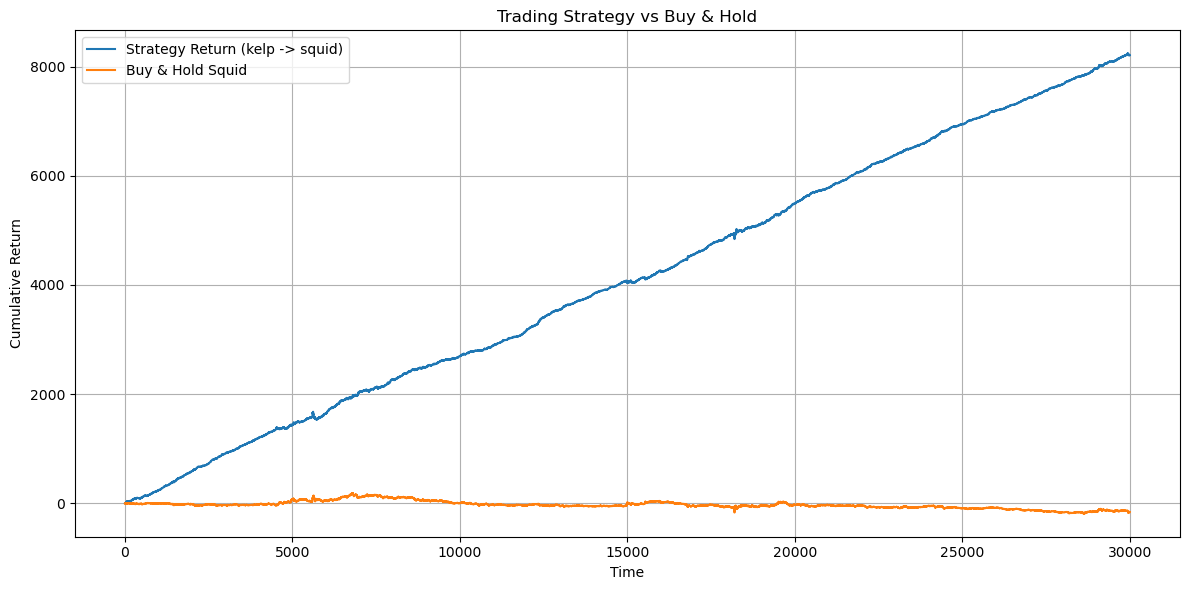

In [20]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

# 1. Prepare data
df = merged_sorted[['mid_price_kelp_diff', 'mid_price_squid_diff']].dropna().copy()

# 2. Fit VAR model
model = VAR(df)
results = model.fit(maxlags=5, ic='aic')  # You can adjust maxlags
print(results.summary())

# 3. In-sample forecast
lag_order = results.k_ar
forecast = results.fittedvalues

# Align actual data with forecast
df = df.iloc[lag_order:]  # drop initial rows with NaNs due to lags
forecast = forecast[['mid_price_squid_diff']]  # we're predicting squid only

# 4. Generate trading signals
df['predicted_squid_diff'] = forecast
df['signal'] = np.sign(df['predicted_squid_diff'])  # +1 = long, -1 = short

# 5. Calculate strategy returns
df['strategy_return'] = df['signal'] * df['mid_price_squid_diff']

# 6. Cumulative returns
df['cumulative_strategy_return'] = df['strategy_return'].cumsum()
df['cumulative_squid_return'] = df['mid_price_squid_diff'].cumsum()

# 7. Plot
plt.figure(figsize=(12, 6))
plt.plot(df['cumulative_strategy_return'], label='Strategy Return (kelp -> squid)')
plt.plot(df['cumulative_squid_return'], label='Buy & Hold Squid')
plt.title('Trading Strategy vs Buy & Hold')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\cam42\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 10, Apr, 2025
Time:                     01:19:30
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.146349
Nobs:                     29994.0    HQIC:                  0.142210
Log likelihood:          -87200.7    FPE:                    1.15057
AIC:                     0.140254    Det(Omega_mle):         1.14972
--------------------------------------------------------------------
Results for equation mid_price_kelp_diff
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                           0.003068         0.003657            0.839           0.401
L1.mid_price_kelp_diff         -0.713176         0.005926         -120.351           0.000
L1.mid

C:\Users\cam42\AppData\Local\Temp\ipykernel_3000\2841970169.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_kelp_diff'] = forecast['mid_price_kelp_diff']
C:\Users\cam42\AppData\Local\Temp\ipykernel_3000\2841970169.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_squid_diff'] = forecast['mid_price_squid_diff']
C:\Users\cam42\AppData\Local\Temp\ipykernel_3000\2841970169.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

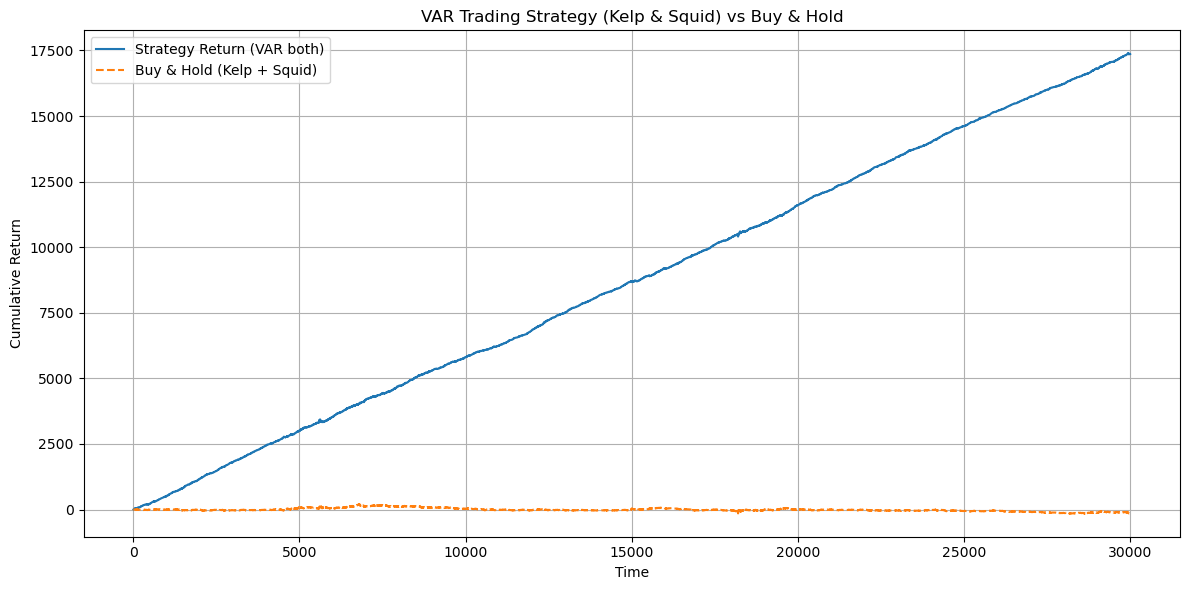

In [21]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

# 1. Prepare data
df = merged_sorted[['mid_price_kelp_diff', 'mid_price_squid_diff']].dropna().copy()

# 2. Fit VAR model
model = VAR(df)
results = model.fit(maxlags=5, ic='aic')  # Let AIC choose the best lag
print(results.summary())

# 3. In-sample forecast
lag_order = results.k_ar
forecast = results.fittedvalues

# 4. Align actual data with forecast
df = df.iloc[lag_order:]  # drop first rows due to lag
forecast = forecast[['mid_price_kelp_diff', 'mid_price_squid_diff']]

df['predicted_kelp_diff'] = forecast['mid_price_kelp_diff']
df['predicted_squid_diff'] = forecast['mid_price_squid_diff']

# 5. Generate trading signals for both assets
df['kelp_signal'] = np.sign(df['predicted_kelp_diff'])
df['squid_signal'] = np.sign(df['predicted_squid_diff'])

# 6. Calculate individual strategy returns
df['kelp_strategy_return'] = df['kelp_signal'] * df['mid_price_kelp_diff']
df['squid_strategy_return'] = df['squid_signal'] * df['mid_price_squid_diff']

# 7. Combined strategy return
df['strategy_return'] = df['kelp_strategy_return'] + df['squid_strategy_return']

# 8. Cumulative returns
df['cumulative_strategy_return'] = df['strategy_return'].cumsum()
df['cumulative_kelp_return'] = df['mid_price_kelp_diff'].cumsum()
df['cumulative_squid_return'] = df['mid_price_squid_diff'].cumsum()
df['cumulative_buy_and_hold'] = df['cumulative_kelp_return'] + df['cumulative_squid_return']

# 9. Plot
plt.figure(figsize=(12, 6))
plt.plot(df['cumulative_strategy_return'], label='Strategy Return (VAR both)')
plt.plot(df['cumulative_buy_and_hold'], label='Buy & Hold (Kelp + Squid)', linestyle='--')
plt.title('VAR Trading Strategy (Kelp & Squid) vs Buy & Hold')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Training model

In [22]:
for i in range(1, 11):
    model = VAR(df)
    results = model.fit(i)
    forecast = results.fittedvalues
    lag_order = results.k_ar
    temp_df = df.iloc[lag_order:].copy()
    forecast = forecast[['mid_price_kelp_diff', 'mid_price_squid_diff']]
    
    temp_df['kelp_signal'] = np.sign(forecast['mid_price_kelp_diff'])
    temp_df['squid_signal'] = np.sign(forecast['mid_price_squid_diff'])
    temp_df['strategy_return'] = (
        temp_df['kelp_signal'] * temp_df['mid_price_kelp_diff'] +
        temp_df['squid_signal'] * temp_df['mid_price_squid_diff']
    )
    cumulative_return = temp_df['strategy_return'].cumsum().iloc[-1]
    print(f"Lag {i} - Cumulative Return: {cumulative_return}")


c:\Users\cam42\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Lag 1 - Cumulative Return: 17514.5


c:\Users\cam42\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Lag 2 - Cumulative Return: 17396.0


c:\Users\cam42\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Lag 3 - Cumulative Return: 17580.0


c:\Users\cam42\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Lag 4 - Cumulative Return: 17327.0


c:\Users\cam42\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Lag 5 - Cumulative Return: 17409.0


c:\Users\cam42\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Lag 6 - Cumulative Return: 17307.0


c:\Users\cam42\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Lag 7 - Cumulative Return: 17339.5


c:\Users\cam42\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Lag 8 - Cumulative Return: 17312.0


c:\Users\cam42\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Lag 9 - Cumulative Return: 17405.0


c:\Users\cam42\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Lag 10 - Cumulative Return: 17488.0


### mean reverting relation between kelp and squid

In [23]:
merged_sorted

,day,timestamp,mid_price_kelp,mid_price_squid,rolling_corr,mid_price_kelp_diff,mid_price_squid_diff
0,-2,0,2000.0,2000.0,NaN,NaN,NaN
1,-2,100,2001.0,2000.0,NaN,1.0,0.0
2,-2,200,2000.5,1998.5,NaN,-0.5,-1.5
3,-2,300,2000.5,1998.5,NaN,0.0,0.0
4,-2,400,2000.5,1998.0,NaN,0.0,-0.5
...,...,...,...,...,...,...,...
29995,0,999500,2033.5,1831.5,-0.241732,0.0,1.0
29996,0,999600,2033.5,1833.0,-0.539224,0.0,1.5
29997,0,999700,2034.5,1834.5,0.654276,1.0,1.5
29998,0,999800,2033.0,1838.0,-0.031918,-1.5,3.5


In [27]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Step 1: Extract the two price series
kelp_prices = merged_sorted["mid_price_kelp"]
squid_prices = merged_sorted["mid_price_squid"]

# Step 2: Regress KELP on SQUID (you can reverse if you prefer)
X = sm.add_constant(squid_prices)
model = sm.OLS(kelp_prices, X).fit()
residuals = model.resid

# Step 3: ADF test on the residuals to check for stationarity
adf_result = adfuller(residuals)

# Output results
print("=== Engle-Granger Cointegration Test ===")
print(f"Regression: KELP ~ SQUID")
print(f"Hedge ratio (beta): {model.params[1]}")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print("Conclusion:", "Cointegrated (Mean-Reverting)" if adf_result[1] < 0.07 else "Not Cointegrated (No Mean-Reversion)")


=== Engle-Granger Cointegration Test ===
Regression: KELP ~ SQUID
Hedge ratio (beta): -0.09494062962894304
ADF Statistic: -2.7728300253664844
p-value: 0.06226083688946984
Conclusion: Cointegrated (Mean-Reverting)
